# Overview
Steps to build the network:

1. Load the training data and do a train/validation split.
3. Build a convolutional neural network to classify traffic signs.
4. Build a feedforward neural network to classify traffic signs.
5. Evaluate performance of final neural network on testing data.


In [71]:
import pandas as pd
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
import math

from keras.models import Sequential
from keras.layers import Dense, Activation
import cv2

import json
import random

Load the Data

In [72]:
# read new images

data = pd.read_csv('data/new_data/new_log.csv',
                   dtype={'center': str,'steering': np.float32},
                   skipinitialspace=1)
print(data.dtypes)

X_train = data['center']
y_train = data['steering']

print('Training data size = ', len(X_train))
print('Training labels size = ',len(y_train))

print('Data loaded')


center       object
steering    float32
dtype: object
Training data size =  13626
Training labels size =  13626
Data loaded


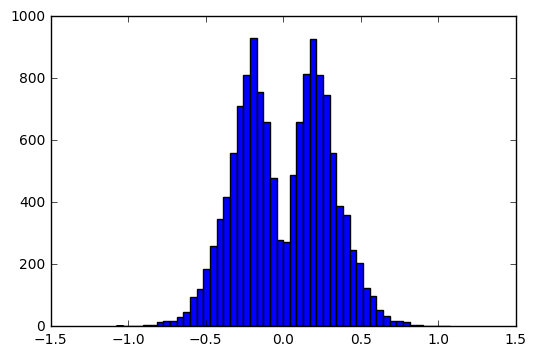

X_train: 13626
y_train: 13626


In [73]:
# examine the data
import matplotlib.pyplot as plt
plt.hist(y_train,50)
plt.show()
data = list(X_train)
labels = list(y_train)
print('X_train:',len(X_train))
print('y_train:',len(y_train))

In [74]:
from sklearn.model_selection import train_test_split

# split data into train, validate and test data
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.3,random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.2,random_state=42)
#print(X_train.shape[0])
print('Data splitted into train, validation anda test data')
print('Training data size = ', len(X_train))
print('Training labels size = ',len(y_train))
print('Validation data size = ',len(X_val))
print('Validation labels size = ',len(y_val))
print('Test data size = ',len(X_test))
print('Test labels size = ',len(y_test))

Data splitted into train, validation anda test data
Training data size =  9538
Training labels size =  9538
Validation data size =  3270
Validation labels size =  3270
Test data size =  818
Test labels size =  818


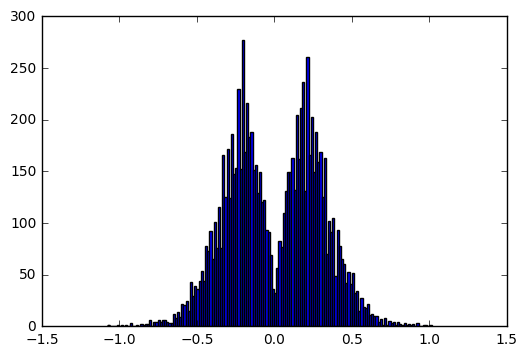

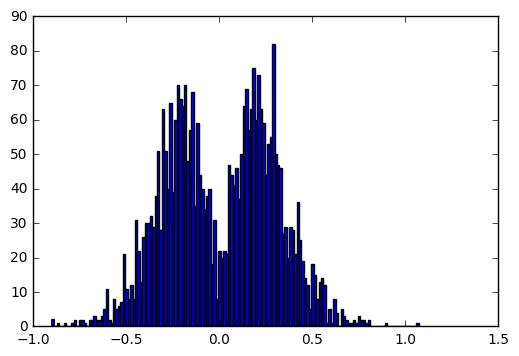

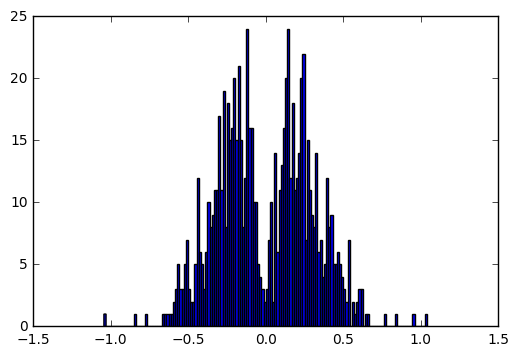

In [75]:
plt.hist(y_train,150)
plt.show()
plt.hist(y_val,150)
plt.show()
plt.hist(y_test,150)
plt.show()

In [76]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Lambda
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization

# define the model
model = Sequential()
model.add(Lambda(lambda x: x/255 - 0.5, input_shape=(80, 300, 3),output_shape=(80, 300, 3)))
model.add(Conv2D(24, 5, 5,subsample=(2, 2),W_regularizer='l2',dim_ordering='tf'))
model.add(BatchNormalization()) #normalisation should be done before activation
model.add(Activation('relu'))
model.add(Conv2D(36, 5, 5,subsample=(2, 2),W_regularizer='l2',dim_ordering='tf'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(48, 5, 5,subsample=(2, 2),W_regularizer='l2',dim_ordering='tf'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, 3, 3,subsample=(1, 1),W_regularizer='l2',dim_ordering='tf'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, 3, 3,subsample=(1, 1),W_regularizer='l2',dim_ordering='tf'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(100, name='fc1'))
model.add(BatchNormalization(mode=1))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(50, name='fc2'))
model.add(BatchNormalization(mode=1))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(10, name='fc3'))
model.add(BatchNormalization(mode=1))
model.add(Activation('relu'))
model.add(Dense(1,name='output'))

# for a mean squared error regression problem
model.compile(optimizer=Adam(lr=0.0001),loss='mean_squared_error')
model.summary()
print('Model defined')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_11 (Lambda)               (None, 80, 300, 3)    0           lambda_input_11[0][0]            
____________________________________________________________________________________________________
convolution2d_50 (Convolution2D) (None, 38, 148, 24)   1824        lambda_11[0][0]                  
____________________________________________________________________________________________________
batchnormalization_52 (BatchNorm (None, 38, 148, 24)   48          convolution2d_50[0][0]           
____________________________________________________________________________________________________
activation_80 (Activation)       (None, 38, 148, 24)   0           batchnormalization_52[0][0]      
___________________________________________________________________________________________

In [77]:
from PIL import Image
    
def generator(X, Y):
    while 1:
        for (x, y) in zip(X, Y):
            path, angle = (x, y)
            angle = np.reshape(angle, [1])
            image = Image.open('./data/new_data/' + path)
            image_array = np.asarray(image)
            transformed_image_array = image_array[None, :, :, :]
            yield transformed_image_array, angle

IMG/image_1533.jpg


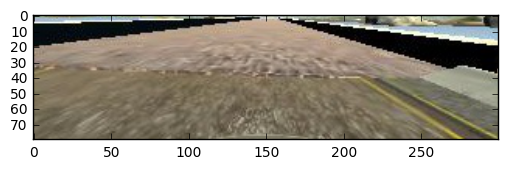

In [78]:
# image example from dataset
print(X_train[0])
image = Image.open('./data/new_data/' + X_train[0])
image_array = np.asarray(image)
plt.imshow(image)
plt.show()

In [79]:
#train the model
from keras.callbacks import ModelCheckpoint
print('')
iterations = 30
train_batch_size = 100
val_batch_size = 100

# checkpoint
filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, verbose=1, monitor = 'val_loss', save_best_only=True, mode='min')
callbacks_list = [checkpoint]
history = model.fit_generator(generator(X_train, y_train), 
                    samples_per_epoch= train_batch_size,
                    nb_epoch=iterations,
                    callbacks=callbacks_list,
                    verbose=1,
                    validation_data=generator(X_val, y_val),
                    nb_val_samples=val_batch_size)

print('----------------- Model trained! -----------------')


Epoch 1/30
100/100 [==============================] - 9s - loss: 0.4060 - val_loss: 0.2249
Epoch 2/30
100/100 [==============================] - 3s - loss: 0.3025 - val_loss: 0.1884
Epoch 3/30
100/100 [==============================] - 3s - loss: 0.2932 - val_loss: 0.0894
Epoch 4/30
100/100 [==============================] - 3s - loss: 0.3075 - val_loss: 0.0749
Epoch 5/30
100/100 [==============================] - 3s - loss: 0.2777 - val_loss: 0.0427
Epoch 6/30
100/100 [==============================] - 3s - loss: 0.2749 - val_loss: 0.0474
Epoch 7/30
100/100 [==============================] - 3s - loss: 0.2538 - val_loss: 0.0468
Epoch 8/30
100/100 [==============================] - 3s - loss: 0.2610 - val_loss: 0.0538
Epoch 9/30
100/100 [==============================] - 4s - loss: 0.2576 - val_loss: 0.0353
Epoch 10/30
100/100 [==============================] - 3s - loss: 0.2501 - val_loss: 0.0229
Epoch 11/30
100/100 [==============================] - 3s - loss: 0.2543 - val_loss: 0.0

In [80]:
from keras.models import model_from_json
import json

# convert model to json format
json_string = model.to_json()
with open('model_at_end.json', 'w') as outfile:
    json.dump(json_string, outfile)

#save model to files
model.save_weights('model_at_end.h5')

print('Model saved to file.')

Model saved to file.


In [11]:
# evaluate the model
scores = model.evaluate_generator(generator(X_test, y_test),len(X_test))
print(scores)

0.0402122680105


In [ ]:
from keras.models import load_model
# returns a compiled model
# identical to the previous one
model = load_model('model.h5')